In [1]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 17kB/s 
     |████████████████████████████████| 4.0MB 36kB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.callbacks.hooks import *
from fastai.vision.interpret import SegmentationInterpretation

import os
import cv2 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import auc,roc_curve
from sklearn.metrics import classification_report

In [4]:
path = Path('/content/gdrive/MyDrive/AMD_Data')
train_path = (path/'Training400')
ann_train_path = (path/'Training400-Lesion/Lesion_Masks')
path.ls()
ann_train_path.ls()

[PosixPath('/content/gdrive/MyDrive/AMD_Data/Training400-Lesion/Lesion_Masks/.DS_Store'),
 PosixPath('/content/gdrive/MyDrive/AMD_Data/Training400-Lesion/Lesion_Masks/drusen'),
 PosixPath('/content/gdrive/MyDrive/AMD_Data/Training400-Lesion/Lesion_Masks/others'),
 PosixPath('/content/gdrive/MyDrive/AMD_Data/Training400-Lesion/Lesion_Masks/scar'),
 PosixPath('/content/gdrive/MyDrive/AMD_Data/Training400-Lesion/Lesion_Masks/exudate'),
 PosixPath('/content/gdrive/MyDrive/AMD_Data/Training400-Lesion/Lesion_Masks/hemorrhage'),
 PosixPath('/content/gdrive/MyDrive/AMD_Data/Training400-Lesion/Lesion_Masks/Glaucoma'),
 PosixPath('/content/gdrive/MyDrive/AMD_Data/Training400-Lesion/Lesion_Masks/Non-Glaucoma')]

In [5]:
mask_f=(ann_train_path/'scar').ls()[0]
mask = open_mask(mask_f)
print(mask.shape)

torch.Size([1, 2056, 2124])


In [6]:
train_path.ls()

[PosixPath('/content/gdrive/MyDrive/AMD_Data/Training400/Non-AMD'),
 PosixPath('/content/gdrive/MyDrive/AMD_Data/Training400/AMD'),
 PosixPath('/content/gdrive/MyDrive/AMD_Data/Training400/models')]

In [7]:
len((train_path/'Non-AMD').ls()),len((train_path/'AMD').ls())

(311, 89)

In [8]:
img = open_image((train_path/'AMD').ls()[0])
print(img.shape)

torch.Size([3, 2056, 2124])


In [9]:
disk_masks_path = (path/'DF/Training400/Disc_Masks')
len(disk_masks_path.ls())

400

#  Classification

In [10]:
classes= ['Non-AMD','AMD']
get_labels = lambda x: x.parts[-2]

src = (ImageList.from_folder(train_path)
       .split_by_rand_pct()
       .label_from_func(get_labels, classes=classes))

def get_data(bs, sz):
  return (src.transform(get_transforms(flip_vert=True), size=sz)
          .databunch(bs= bs, num_workers=4)
          .normalize(imagenet_stats))

In [11]:
%time data= get_data(64,224)

CPU times: user 9.07 s, sys: 313 ms, total: 9.38 s
Wall time: 27.3 s


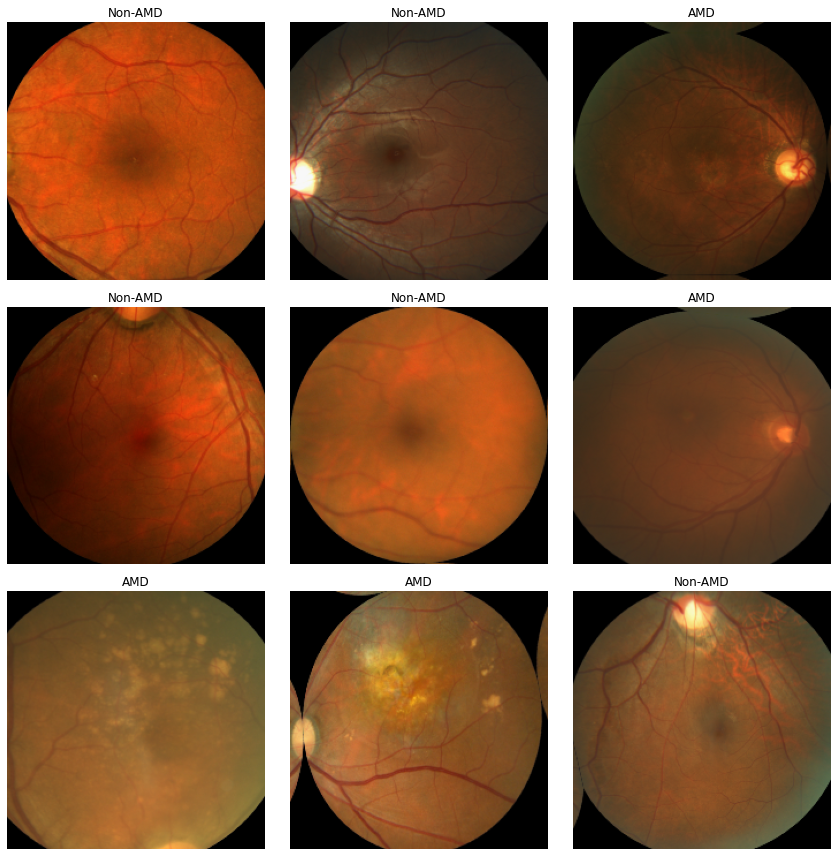

In [12]:
data.show_batch(rows=3)

# Training

In [13]:
cbfs = [ReduceLROnPlateauCallback,
        partial(SaveModelCallback,every='epoch',name='res50_224'),
        ShowGraph]

In [14]:
learner = cnn_learner(data, models.resnet50, metrics= [accuracy], callback_fns=cbfs)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


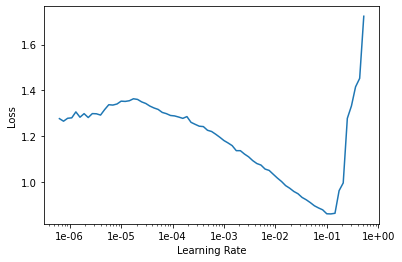

In [ ]:
learner.lr_find()
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.204763,0.699382,0.650000,00:53
1,1.154154,0.674738,0.737500,00:43
2,1.045486,0.526041,0.837500,00:43
3,0.945645,0.607167,0.775000,00:43
4,0.837505,0.793484,0.712500,00:43
5,0.715525,0.558353,0.862500,00:43
6,0.630970,0.563039,0.850000,00:43
7,0.550715,0.472442,0.887500,00:43
8,0.489429,0.592738,0.875000,00:43
9,0.441520,0.665545,0.850000,00:43


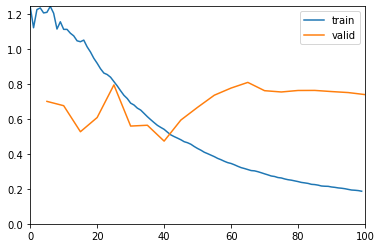

Epoch 3: reducing lr to 0.0015200000000000003
Epoch 4: reducing lr to 0.0018713843876330617
Epoch 5: reducing lr to 0.0020000000000000005
Epoch 6: reducing lr to 0.001974928012470175
Epoch 8: reducing lr to 0.0017818323551421003
Epoch 9: reducing lr to 0.0016234913078995265
Epoch 10: reducing lr to 0.001433886003582602
Epoch 11: reducing lr to 0.0012225240438725788
Epoch 12: reducing lr to 0.0010000040000000003
Epoch 13: reducing lr to 0.0007774839561274217
Epoch 14: reducing lr to 0.0005661219964173986
Epoch 15: reducing lr to 0.00037651669210047407
Epoch 16: reducing lr to 0.00021817564485790013


In [ ]:
lr= 1e-1
learner.fit_one_cycle(20, slice(1e-3,1e-2, lr))

In [ ]:
learner.save('res50_224_classification-90acc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


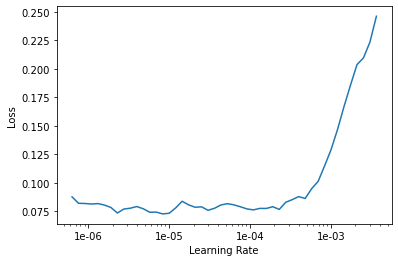

In [ ]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.117821,0.733950,0.887500,00:45
1,0.111054,0.737989,0.887500,00:45
2,0.090106,0.736422,0.887500,00:45
3,0.087819,0.710927,0.887500,00:45
4,0.080765,0.725312,0.875000,00:45
5,0.075006,0.718746,0.875000,00:45
6,0.071903,0.737940,0.887500,00:44
7,0.066907,0.728717,0.887500,00:45
8,0.067777,0.711123,0.875000,00:45
9,0.060929,0.664462,0.862500,00:45


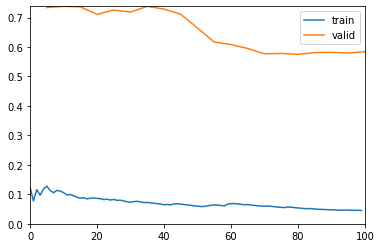

In [ ]:
lr= 1e-4
learner.fit_one_cycle(20, slice(1e-5, lr))

In [ ]:
data512=get_data(24,512)

In [ ]:
learner= cnn_learner(data512, models.resnet50, metrics= [accuracy], callback_fns=cbfs).load('res50_224_classification-90acc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


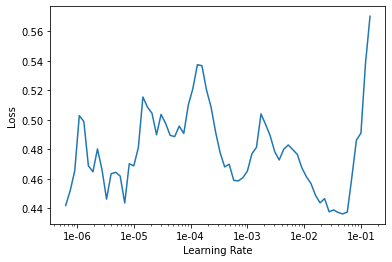

In [ ]:
learner.lr_find()
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.450491,0.396182,0.887500,01:05
1,0.384827,0.430707,0.900000,01:03
2,0.328044,0.428223,0.862500,01:03
3,0.306340,0.332011,0.925000,01:03
4,0.273634,0.520704,0.887500,01:03
5,0.304047,0.548552,0.850000,01:03
6,0.309291,0.724840,0.862500,01:03
7,0.363058,0.443321,0.912500,01:03
8,0.303869,0.312270,0.912500,01:02
9,0.258157,0.375003,0.887500,01:03


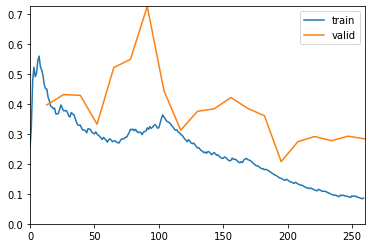

Epoch 1: reducing lr to 0.0005600000000000001
Epoch 2: reducing lr to 0.0010400000000000001
Epoch 4: reducing lr to 0.0018713843876330617
Epoch 5: reducing lr to 0.0020000000000000005
Epoch 6: reducing lr to 0.001974928012470175
Epoch 7: reducing lr to 0.0019009692640269478
Epoch 9: reducing lr to 0.0016234913078995265
Epoch 10: reducing lr to 0.001433886003582602
Epoch 11: reducing lr to 0.0012225240438725788
Epoch 12: reducing lr to 0.0010000040000000003
Epoch 13: reducing lr to 0.0007774839561274217
Epoch 15: reducing lr to 0.00037651669210047407
Epoch 16: reducing lr to 0.00021817564485790013


In [ ]:
learner.fit_one_cycle(20, slice(1e-3,1e-2))

In [ ]:
learner.save('res50_224_classification-91acc')

In [ ]:
learner.load('res50_224_classification-91acc')

Learner(data=ImageDataBunch;

Train: LabelList (320 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
Non-AMD,Non-AMD,Non-AMD,Non-AMD,Non-AMD
Path: /content/gdrive/MyDrive/AMD_Data/Training400;

Valid: LabelList (80 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
Non-AMD,Non-AMD,Non-AMD,AMD,AMD
Path: /content/gdrive/MyDrive/AMD_Data/Training400;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): Bat

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


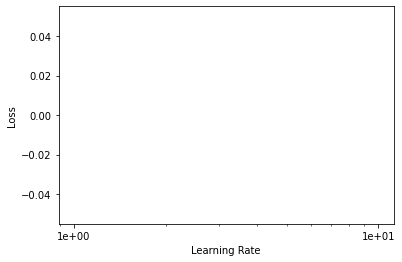

In [ ]:
learner.to_fp16()
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.031535,0.291186,0.937500,01:03
1,0.044806,0.299294,0.937500,01:01
2,0.033570,0.301895,0.937500,01:01


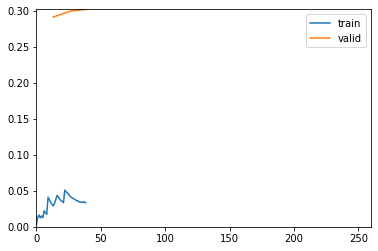

KeyboardInterrupt: ignored

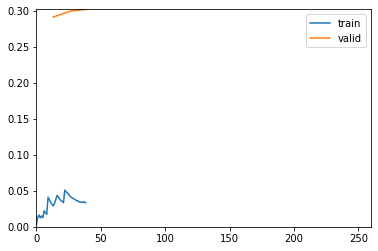

In [ ]:
lr= 1e-4
learner.fit_one_cycle(20, slice(1e-5, lr))

In [ ]:
learner.save('res50_512_classification-985acc')

# Evaluation

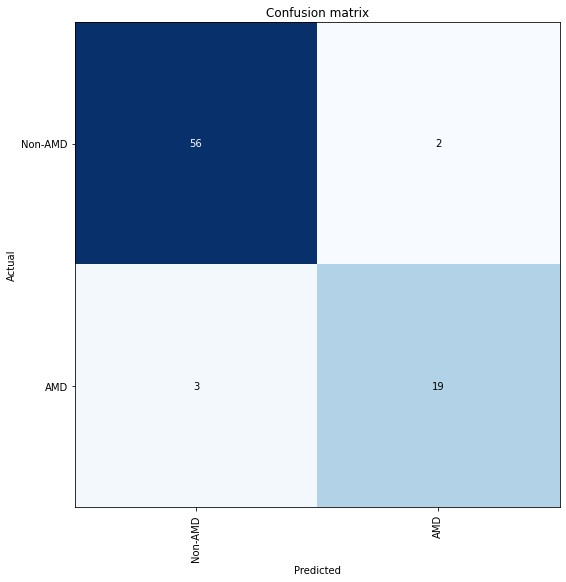

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(10,8))

In [ ]:
# Predictions of the validation data
preds, y_true=learner.get_preds()
y_true.shape, preds.shape

(torch.Size([80]), torch.Size([80, 2]))

In [ ]:
y_true=y_true.numpy() 
preds=np.argmax(preds.numpy(), axis=-1)
y_true.shape, preds.shape

((80,), (80,))

In [ ]:
# Generate a classification report
report = classification_report(y_true, preds, target_names=classes)
print(report)

              precision    recall  f1-score   support

     Non-AMD       0.95      0.97      0.96        58
         AMD       0.90      0.86      0.88        22

    accuracy                           0.94        80
   macro avg       0.93      0.91      0.92        80
weighted avg       0.94      0.94      0.94        80



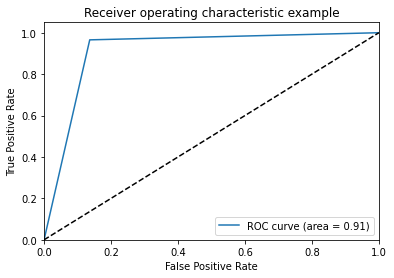

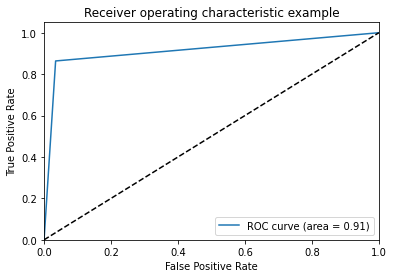

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=len(classes)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_true))[:, i], np.array(pd.get_dummies(preds))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

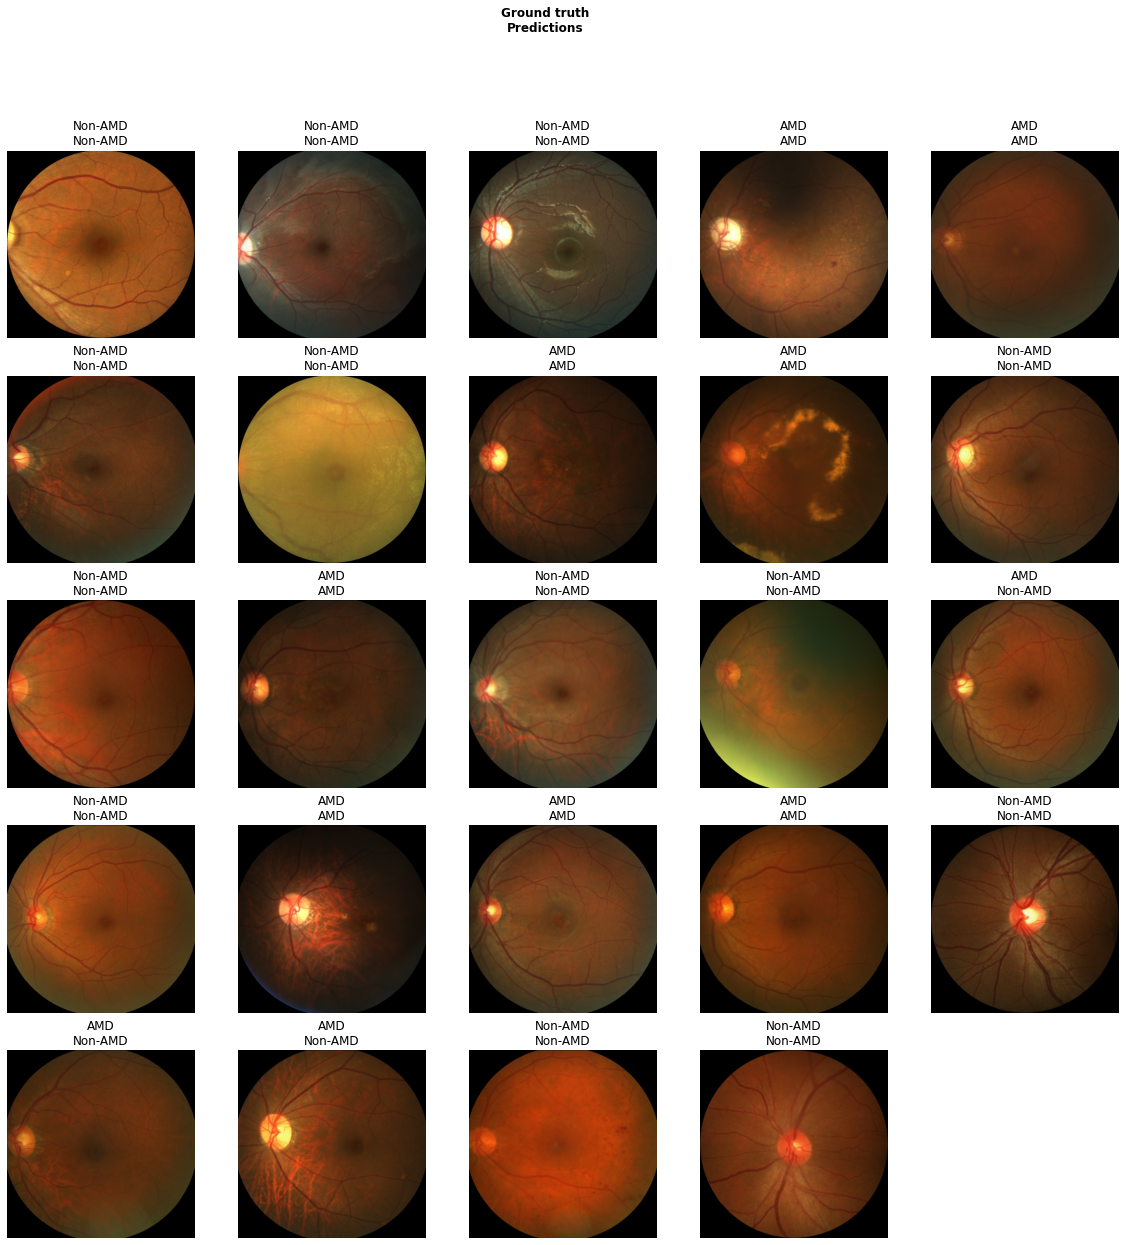

In [ ]:
learner.show_results()

## Save model

In [ ]:
learner.export(file='models/res50_512_classification-985acc.pkl')

In [ ]:
stage_model= 'res50_512_classification-985acc.pth'
model_file = 'res50_512_classification-985acc.pkl'
path_local_models = (train_path/'models')
model_local_path = str(path_local_models/stage_model)
# upload_files_to_gcp(model_local_path, path_ophthalmology_models)
# ls_gcp(path_ophthalmology_models)

In [ ]:
path

PosixPath('/content/gdrive/MyDrive/AMD_Data')

## Heat map

In [ ]:
def heatMap(x, data, learner, size=(0,224,224,0)):
    """HeatMap"""
    
    # Evaluation mode
    m=learner.model.eval()
    
    # Denormalize the image
    xb,_ = data.one_item(x)
    xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()
    
    # hook the activations
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0, 1].backward()

    # Activations    
    acts=hook_a.stored[0].cpu()
    
    # Avg of the activations
    avg_acts=acts.mean(0)
    
    # Show HeatMap
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(avg_acts, alpha=0.6, extent=size,
              interpolation='bilinear', cmap='magma')

Category 0

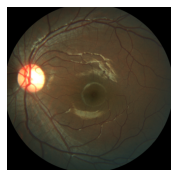

In [ ]:
x,y = data512.valid_ds[2]
x.show()
data512.valid_ds.y[2]

In [ ]:
x= Image(x.data.float())

In [ ]:
learner.to_fp32()

Learner(data=ImageDataBunch;

Train: LabelList (320 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
Non-AMD,Non-AMD,Non-AMD,Non-AMD,Non-AMD
Path: /content/gdrive/MyDrive/AMD_Data/Training400;

Valid: LabelList (80 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
Non-AMD,Non-AMD,Non-AMD,AMD,AMD
Path: /content/gdrive/MyDrive/AMD_Data/Training400;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): Bat

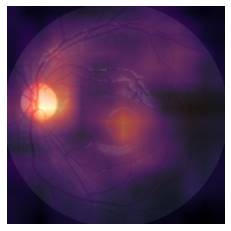

In [ ]:
heatMap(x, data512, learner, size=(0, 512, 512, 0))

In [ ]:
class Inference():

    def __init__(self, path, file_name):
        """ Inference 
        :path = path to the .pkl file
        :file_name
        return: class prediction
        """
        self.learner = load_learner(path, file_name)
        self.learner.to_fp32()
        self.classes= self.learner.data.single_ds.y.classes

    def __call__(self, img, print_probs=True, heatmap=False):
        img = open_image(img) if not isinstance(
            img, fastai.vision.image.Image) else img
        pred_class, idx, probs = self.learner.predict(img)
        
        if print_probs:
          for i,p in enumerate(probs): print(f"{self.classes[i]} {(p*100):.3f}")
        if heatmap: self.show_heatmap(img)
        return pred_class, idx, probs
      
    def show_heatmap(self, img):
        heatMap(img, self.learner.data, self.learner, size=(0,512,512,0))
        plt.show()

In [ ]:
# path_local_models= 'AMD_Data/Training400/models/'
predict_AMD=Inference(path_local_models, model_file)

In [ ]:
img_f = (train_path/'Non-AMD').ls()[0] # non amd

Non-AMD 100.000
AMD 0.000


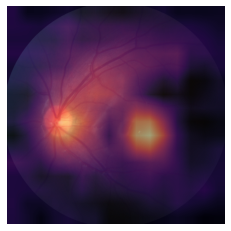

In [ ]:
pred_class, idx, probs=predict_AMD(img_f, heatmap=True)